In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
events = np.loadtxt("../data_processed/events_refact.txt")

In [3]:
def filter_patch(events, patch_center, patch_size):
    x_lim = (patch_center[1] - int(patch_size / 2), patch_center[1] + int(patch_size / 2) - 1)
    y_lim = (patch_center[0] - int(patch_size / 2), patch_center[0] + int(patch_size / 2) - 1)

    events_filtered = np.copy(events)
    events_filtered = events_filtered[
        np.logical_and((x_lim[0] <= events_filtered[:, 1]), (events_filtered[:, 1] <= x_lim[1]))]
    events_filtered = events_filtered[
        np.logical_and((y_lim[0] <= events_filtered[:, 2]), (events_filtered[:, 2] <= y_lim[1]))]
    # events_filtered = events_filtered[[(y_lim[0] >= events_range[:,2]) & (events_range[:,2] <= y_lim[1])]
    #vents_filtered = np.array(events_filtered)

    events_filtered[:,1] = (events_filtered[:,1] - patch_center[1] + int(patch_size / 2)).astype(int)
    events_filtered[:,2] = (events_filtered[:,2] - patch_center[0] + int(patch_size / 2)).astype(int)
    
    return events_filtered

In [4]:
patch_center = (90, 120)
patch_size = 180
shape = (patch_size, patch_size)
events = filter_patch(events, patch_center, patch_size)

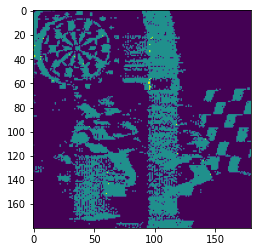

In [5]:
def img_from_events(events, shape):
    img = np.zeros(shape)
    for e in events:
        if e[3] == 1:
            continue
        x = int(e[1])
        y = int(e[2])
        img[y, x] += 1
    return img
plt.imshow(img_from_events(events, shape))

In [6]:
cell_shape = (3, 3)
m = int(cell_shape[0]/2)
sampled_img = np.zeros((patch_size +m, patch_size +m , 2))
thresh = 0.66
for e in events:
    
    x = int(e[1])
    y = int(e[2])
        
    t = e[0]
    
    if e[3] == 1:
        continue
        
    for a in range(x-m, x+m +1):
        for b in range(y-m, y+m +1):
            sampled_img[b, a, 0] += 1

            if (sampled_img[b, a, 0] >= cell_shape[0]*cell_shape[1]*thresh) and sampled_img[b, a, 1] == 0:
                sampled_img[b, a, 1] = t

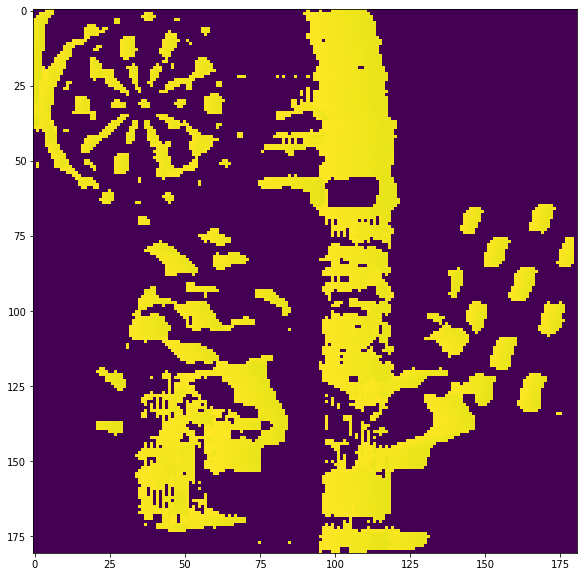

In [7]:
plt.figure(figsize=(10, 10))
plt.imshow(sampled_img[:,:,1])

In [38]:
sampled_diff = np.full(sampled_img[:,:,1].shape, -1.0)
dist = 3
for y in range(sampled_diff.shape[0]):
    for x in range(sampled_diff.shape[1] - dist):
        if sampled_img[y,x+dist,1] == 0:
            continue
        if sampled_img[y,x,1] <= sampled_img[y,x+dist,1]:
            continue
        sampled_diff[y, x] = (sampled_img[y,x,1] - sampled_img[y,x+dist,1]) / dist

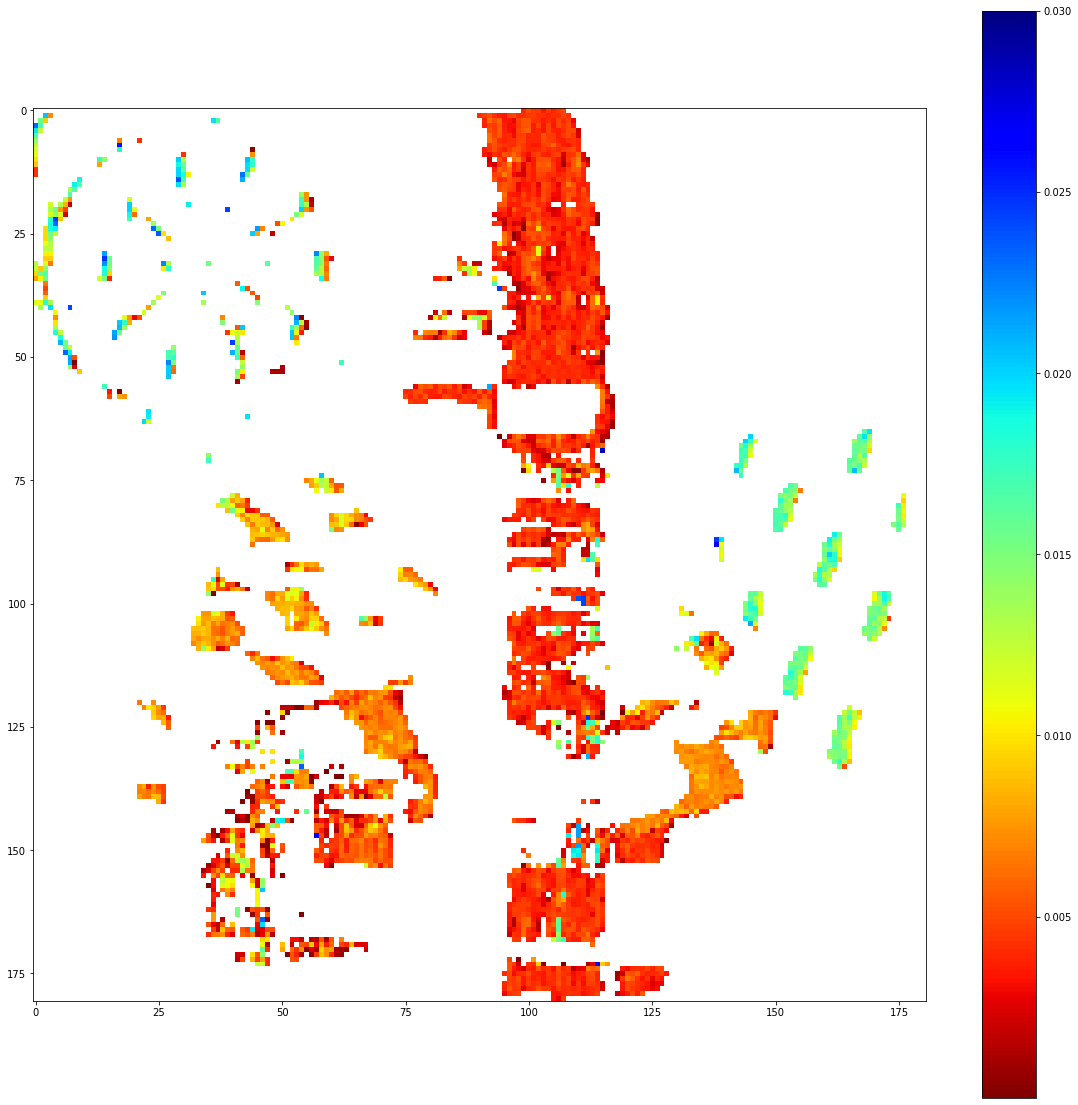

In [39]:
plt.figure(figsize=(20, 20))
# sampled_diff_m = np.ma.masked_where(np.logical_or(sampled_diff <= 0, sampled_diff>1.325), sampled_diff)
sampled_diff_m = np.ma.masked_where(sampled_diff <= 0, sampled_diff)

m = plt.imshow(sampled_diff_m, cmap="jet_r", vmax=0.03)
plt.colorbar(mappable=m)

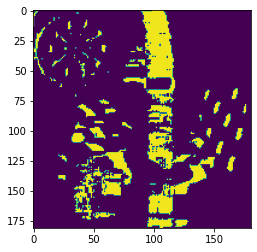

In [40]:
plt.imshow(sampled_diff)

In [41]:
u = 1 / sampled_diff_m

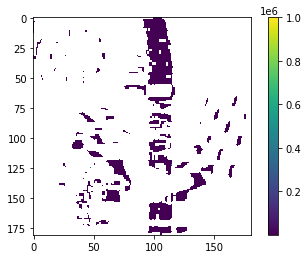

In [42]:
m = plt.imshow(u)
plt.colorbar(m)

In [43]:
v = 0.2901460156636141

In [44]:
f = 335.419462958

In [45]:
d = (f / u) * v

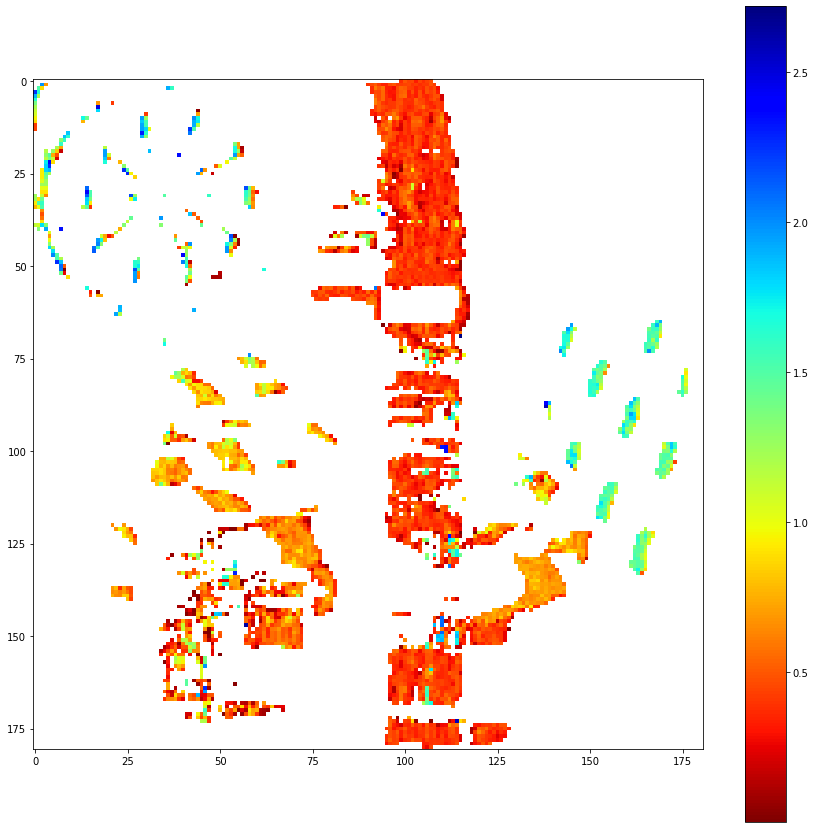

In [46]:
plt.figure(figsize=(15, 15))
m = plt.imshow(d, cmap="jet_r")
plt.colorbar(m)

In [17]:
patch_dim = 10
avg_patches = np.zeros((int(sampled_diff.shape[0]/patch_dim), int(sampled_diff.shape[1]/patch_dim)))
for x in range(avg_patches.shape[1]):
    for y in range(avg_patches.shape[0]):
        avg_patches[y, x] = np.average(sampled_diff_m[y*patch_dim:y*patch_dim+patch_dim, x*patch_dim:x*patch_dim+patch_dim])

C:\Users\schiavaz\AppData\Local\Temp/ipykernel_10984/1347558850.py:5: UserWarning: Warning: converting a masked element to nan.
  avg_patches[y, x] = np.average(sampled_diff_m[y*patch_dim:y*patch_dim+patch_dim, x*patch_dim:x*patch_dim+patch_dim])


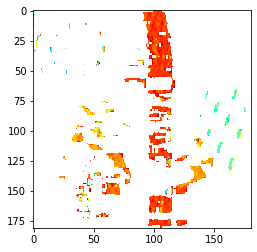

In [18]:
plt.imshow(sampled_diff_m, cmap="jet_r")

In [19]:
patch_dim = 3
iqr_patches = np.zeros((int(sampled_diff.shape[0]/patch_dim), int(sampled_diff.shape[1]/patch_dim)))
for x in range(iqr_patches.shape[1]):
    for y in range(iqr_patches.shape[0]):
        s = sampled_diff_m[y*patch_dim:y*patch_dim+patch_dim, x*patch_dim:x*patch_dim+patch_dim]
        mdata = np.ma.filled(s, np.nan)
        iqr_patches[y, x] = np.nanpercentile(mdata, 50)

c:\users\schiavaz\lava-nc\venv\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


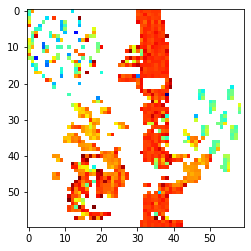

In [20]:
plt.imshow(iqr_patches, cmap="jet_r")

In [21]:
patch_dim = 4
median_patches = np.zeros((int(sampled_diff.shape[0]/patch_dim), int(sampled_diff.shape[1]/patch_dim)))
for x in range(median_patches.shape[1]):
    for y in range(median_patches.shape[0]):
        s = sampled_diff_m[y*patch_dim:y*patch_dim+patch_dim, x*patch_dim:x*patch_dim+patch_dim]
        median_patches[y, x] = np.ma.median(s)

C:\Users\schiavaz\AppData\Local\Temp/ipykernel_10984/744758522.py:6: UserWarning: Warning: converting a masked element to nan.
  median_patches[y, x] = np.ma.median(s)


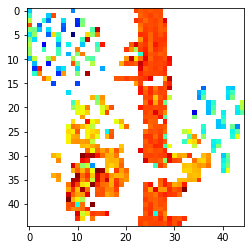

In [22]:
plt.imshow(median_patches, cmap="jet_r")

In [23]:
median_diff = np.copy(sampled_diff)

In [24]:
for y in range(median_diff.shape[0]-1):
    for x in range(median_diff.shape[1]-1):
        if median_diff[y, x] > 0:
            median_diff[y, x] = median_patches[int(y/patch_dim), int(x/patch_dim)]

In [25]:
median_diff_m = np.ma.masked_where(median_diff <= 0, median_diff)

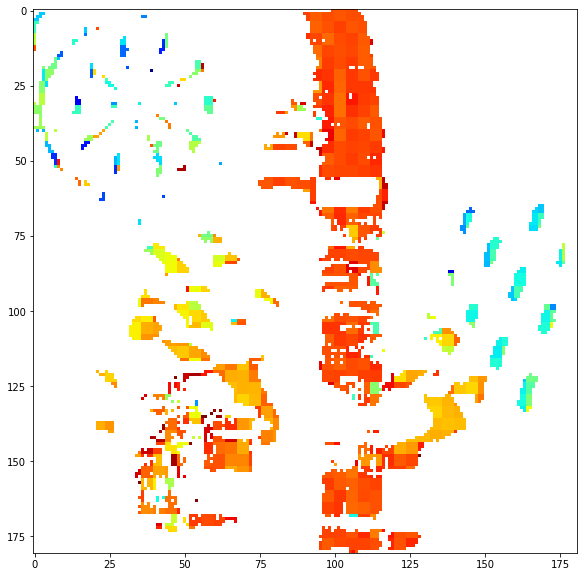

In [26]:
plt.figure(figsize=(10, 10))
plt.imshow(median_diff_m, cmap="jet_r")

In [27]:
median_diff

array([[-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        ,  0.01633283, ..., -1.        ,
        -1.        , -1.        ],
       [-1.        ,  0.01633283,  0.01633283, ..., -1.        ,
        -1.        , -1.        ],
       ...,
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ]])